# Описание проекта.

<font size="4"><b>Заказчик проекта:</b></font> 

Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.   

Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.  
  
<font size="4"><b>Цель проекта:</b></font> 

Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru  
  
<font size="4"><b>Задача:</b></font>  

Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом.   

<font size="4"><b>План работы:</b></font>  
1. Загрузка датасетов и ознакомление с данными.
2. Предварительная обработка и отбор полезных признаков.
3. Объединение датасетов.
4. Подготовка к обучению.
5. Обучение модели.
6. Итоговая оценка качества предсказания.
7. Аналих важности признаков модели.

<font size="4"><b>Датели реализации:</b></font>

В начале проекта будут обработаны датасеты на предмет выбросов и аномальных значений. После обработки будут выбраны полезные признаки, а также убраны те признаки, которые дают утечку целевого признака. Далее будет произведено объединение датасетов 'orders', 'suitable_teachers' и 'teachers_info'. Датасет 'teachers_info' будет предвариетльно агрегирован по выбранным признакам. Далее используя модель CatBoostClassifier обучим на тренировочных выборках, а затем оценим предсказание модели на валидационной и тестовой выборках. В дальнейшем рассмотрим важность признаков.

# Загрузка датасетов и ознакомление с данными.

Импортируем все необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from pymystem3 import Mystem
import re 
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.datasets import make_classification
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score


from feature_engine.selection import DropCorrelatedFeatures
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

from catboost import CatBoostClassifier as clf

In [3]:
state = 12345

В связи с большим размером датасета введем опцию на отмену ограничения отображения признаков.

In [4]:
pd.set_option('display.max_columns', None)

Прочитаем датасеты.

In [5]:
orders = pd.read_feather("orders.feather")
prefered_teachers = pd.read_feather("prefered_teachers_order_id.feather")
suitable_teachers = pd.read_feather("suitable_teachers.feather")
teachers_info = pd.read_feather("teachers_info.feather")

## Ознакомление с датасетом "orders".

Рассмотрим несколько строк датасета 'orders'.

In [6]:
display(orders.head())

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


Просмотрим общую информацию о датасете.

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

Рассмотрим описательную статистику признаков датасета.

In [8]:
orders.describe()

,id,subject_id,lesson_price,lesson_duration,home_metro_id,working_teacher_id,status_id,prefered_teacher_id,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,is_display_to_teachers
count,1.191861e+06,1.181529e+06,1.191861e+06,1.191861e+06,6.424470e+05,7.059880e+05,1.191861e+06,4.000000e+00,1.191861e+06,5.796980e+05,1.032470e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,5.825880e+05,1.191861e+06,1.042385e+06,1.351800e+04,1.191861e+06
mean,2.340488e+06,2.138735e+01,2.019466e+03,7.186754e+01,8.130288e+02,1.644861e+05,2.436352e+01,3.342593e+06,1.952076e+01,6.682231e+05,2.286848e+01,1.423346e+01,2.129868e+02,1.329890e+01,1.268675e+01,1.211135e+01,1.407590e+01,1.160722e+01,1.955505e+01,2.863540e+01,2.237090e-02,9.083526e-02,2.877031e+01,2.325827e+06,9.625180e+05,2.357963e+01,1.388366e+03,9.641678e-01
std,3.445563e+05,6.157333e+03,9.163341e+05,6.130494e+03,8.375082e+03,8.184790e+04,6.130578e+03,1.858466e+05,6.130586e+03,4.013024e+05,6.586820e+03,6.130595e+03,1.111145e+04,6.130597e+03,6.130598e+03,6.130605e+03,6.130596e+03,6.130600e+03,6.130600e+03,6.131385e+03,1.478866e-01,2.873748e-01,6.130570e+03,3.480297e+05,2.177188e+05,6.555417e+03,7.184427e+04,1.858717e-01
min,1.742636e+06,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.300000e+01,1.000000e+00,3.211265e+06,0.000000e+00,4.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e+01,-1.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.041441e+06,3.000000e+00,5.000000e+02,6.000000e+01,2.280000e+02,1.009130e+05,7.000000e+00,3.211265e+06,1.000000e+01,3.046100e+05,8.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,2.022765e+06,8.680830e+05,7.000000e+00,3.000000e+01,1.000000e+00
50%,2.341556e+06,8.000000e+00,1.000000e+03,6.000000e+01,6.440000e+02,1.695160e+05,1.600000e+01,3.276801e+06,1.000000e+01,7.806650e+05,1.000000e+01,3.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,2.318886e+06,9.896330e+05,1.000000e+01,3.000000e+01,1.000000e+00
75%,2.638720e+06,1.300000e+01,1.500000e+03,6.000000e+01,1.146000e+03,2.343302e+05,1.600000e+01,3.408129e+06,1.000000e+01,9.715650e+05,1.200000e+01,4.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,2.000000e+01,4.000000e+01,0.000000e+00,0.000000e+00,2.300000e+01,2.631660e+06,1.125538e+06,1.300000e+01,3.000000e+01,1.000000e+00
max,3.605505e+06,3.605505e+06,1.000000e+09,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,1.000000e+07,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,1.000000e+00,1.000000e+00,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,5.000000e+06,1.000000e+00


Рассмотрим количество пропусков в датасете.

In [9]:
orders.isna().sum()

id                               0
order_date                       0
subject_id                   10332
purpose                     166510
lesson_price                     0
lesson_duration                  0
lesson_place               1191830
home_metro_id               549414
add_info                    147173
start_date                  486283
working_teacher_id          485873
status_id                        0
comments                    850393
prefered_teacher_id        1191857
amount_to_pay                    0
planned_lesson_number            0
first_lesson_date          1025290
creator_id                  612163
pupil_category_new_id       159391
lessons_per_week                 0
minimal_price                    0
teacher_sex                      0
teacher_experience_from          0
teacher_experience_to            0
lesson_place_new                 0
pupil_knowledgelvl               0
teacher_age_from                 0
teacher_age_to                   0
chosen_teachers_only

<b>Выводы:</b>

1) В данном датасете есть признаки, имеющие малое количество ненулевых значений. Это признаки: "lesson_place", "home_metro_id", "start_date", "working_teacher_id", "comments", "prefered_teacher_id", "first_lesson_date", "creator_id", "max_metro_distance", "estimated_fee", "payment_date". Данные признаки будут удалены из датасета. 

2) Необходимо проанализировать численные признаки на выбросы, проверить на адекватность, а также разобраться с категориальными признаками.

## Ознакомление с датасетом "prefered_teachers".

Рассмотрим несколько строк датасета 'prefered_teachers'.

In [10]:
display(prefered_teachers.head())

,order_id,teacher_id
0,2469225,19663
1,2470455,19663
2,2480251,19663
3,2481259,19663
4,2483171,19663


Просмотрим общую информацию о датасете.

In [11]:
prefered_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB


Рассмотрим описательную статистику признаков датасета.

In [12]:
prefered_teachers.describe()

,order_id,teacher_id
count,1.135198e+06,1.135198e+06
mean,2.267043e+06,1.435985e+05
std,3.314427e+05,7.397535e+04
min,1.742638e+06,3.300000e+01
25%,1.984395e+06,8.642300e+04
50%,2.246181e+06,1.443980e+05
75%,2.511700e+06,2.043210e+05
max,2.946594e+06,3.122320e+05


Рассмотрим количество пропусков в датасете.

In [13]:
prefered_teachers.isna().sum()

order_id      0
teacher_id    0
dtype: int64

<b>Вывод:</b>

Данный датасет не будем использовать в данном проекте.

## Ознакомление с датасетом "suitable_teachers".

Рассмотрим несколько строк датасета "suitable_teachers".

In [14]:
display(suitable_teachers.head())

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1


Данный датасет будем использовать как связующий между датасетами 'orders' и 'teachers_info'.

Просмотрим общую информацию о датасете.

In [15]:
suitable_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


Рассмотрим описательную статистику признаков датасета.

In [16]:
suitable_teachers.describe()

,teacher_id,order_id,enable_auto_assign,enable_assign
count,2.027119e+07,2.027119e+07,2.027119e+07,2.027119e+07
mean,1.578108e+05,2.500198e+06,1.291083e-01,2.754817e-02
std,8.024676e+04,3.338940e+05,3.353198e-01,1.636743e-01
min,3.300000e+01,1.742638e+06,0.000000e+00,0.000000e+00
25%,9.542000e+04,2.265722e+06,0.000000e+00,0.000000e+00
50%,1.595950e+05,2.571756e+06,0.000000e+00,0.000000e+00
75%,2.241730e+05,2.779002e+06,0.000000e+00,0.000000e+00
max,3.126610e+05,2.946699e+06,1.000000e+00,1.000000e+00


Рассмотрим количество пропусков в датасете.

In [17]:
suitable_teachers.isna().sum()

teacher_id                   0
order_id                     0
contact_result        12824362
enable_auto_assign           0
enable_assign                0
dtype: int64

<b>Вывод:</b>

В данном датасете пропуски отсутствуют практически по всех признаках, кроме признака "contact_result". В виду большого значения пропусков данный признак будет удален из датасета.

## Ознакомление с датасетом "teachers_info".

Рассмотрим несколько строк датасета "teachers_info".

In [18]:
display(teachers_info.head())

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.0,0,4.679688,1,NaN,1,500,1,NaN,0,1,0,1138.0,237.5,NaN,1,0,492.0,1,NaN,NaN,4.500000,1138.0,6,2022-05-16 18:44:59.993,0,3702.0,2023-11-06 14:20:15.173
1,46,2023-01-19 17:36:42.233,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.0,0,0.000000,1,NaN,3,0,0,NaN,0,1,1,25.0,0.0,NaN,1,1,0.0,1,NaN,NaN,4.300781,25.0,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.0,0,6.000000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.0,0.0,NaN,1,1,2182.0,3,0.0,NaN,4.300781,300.0,0,2017-01-01 00:00:00.000,0,NaN,NaN
3,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.0,0,11.289062,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.0,0.0,NaN,1,1,2084.0,1,0.0,NaN,5.000000,135.0,2,2020-04-01 01:07:44.157,1,NaN,NaN
4,54,2023-01-19 16:28:36.517,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01

Просмотрим общую информацию о датасете.

In [19]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

Рассмотрим описательную статистику признаков датасета.

In [20]:
teachers_info.describe()

,id,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_id,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,is_confirmed,lesson_duration.1,lesson_cost.1,status_id.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,is_confirmed.1,lesson_duration.2,lesson_cost.2,status_id.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,is_confirmed.2,is_display,rating_id,rating,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners,status_institution_id
count,307972.000000,3.079720e+05,307972.000000,307972.000000,307972.000000,307972.000000,3.079720e+05,307972.000000,14873.0,6543.0,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000,3.079720e+05,307972.000000,14873.0,6543.0,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000,3.079720e+05,307972.000000,14873.0,6543.0,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000,11208.000000,307972.000000,307972.0,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000,307972.0,307972.0,1323.0,307972.000000,307972.000000,307972.0,307972.000000,78418.0,307972.000000,307972.0,307972.000000,307972.000000,24902.0
mean,157246.177036,4.861595e+05,0.012732,0.421749,0.599145,61.502978,5.325806e+02,4.176467,inf,inf,0.543734,4.239327,7.420168,0.890305,61.502978,5.325806e+02,4.176467,inf,inf,0.543734,4.239327,7.420168,0.890305,61.502978,5.325806e+02,4.176467,inf,inf,0.543734,4.239327,7.420168,0.890305,0.658735,10.222364,-222.160797,0.947754,0.006910,NaN,8.488928,1.776892,0.345817,0.510696,0.734015,0.796205,0.874622,NaN,NaN,inf,0.468961,0.860702,NaN,0.688316,0.0,NaN,NaN,1.087859,0.841577,inf
std,90198.005463,4.019108e+05,0.112114,0.493840,0.490072,15.061675,2.146357e+03,1.576620,inf,inf,0.498084,1.774220,6.179630,0.312510,15.061675,2.146357e+03,1.576620,inf,inf,0.498084,1.774220,6.179630,0.312510,15.061675,2.146357e+03,1.576620,inf,inf,0.498084,1.774220,6.179630,0.312510,0.474135,6.351313,4706.818114,0.221680,0.082837,NaN,16.442877,0.467861,13.144821,0.499886,0.441857,0.402819,0.331148,NaN,NaN,inf,0.499036,0.346258,NaN,1.091136,0.0,0.000000,NaN,4.863274,0.365138,inf
min,33.000000,4.500000e+01,0.000000,0.000000,0.000000,1.000000,0.000000e+00,1.000000,1.0,3.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,1.0,3.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,1.0,3.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-100500.000000,0.000000,0.000000,-10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,3.0
25%,79390.750000,8.068275e+04,0.000000,0.000000,0.000000,60.000000,0.000000e+00,4.000000,756.0,772.0,0.000000,5.000000,7.000000,1.000000,60.000000,0.000000e+00,4.000000,756.0,772.0,0.000000,5.000000,7.000000,1.000000,60.000000,0.000000e+00,4.000000,756.0,772.0,0.000000,5.000000,7.000000,1.000000,0.000000,2.000000,-2.000000,1.000000,0.000000,0.0,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0,409.5,0.000000,1.000000,0.0,0.000000,0.0,4.300781,0.0,0.000000,1.000000,2034.0
50%,157384.500000,4.314890e+05,0.000000,0.000000,1.000000,60.000000,5.000000e+02,5.000000,2652.0,811.0,1.000000,5.000000,7.000000,1.000000,60.000000,5.000000e+02,5.000000,2652.0,811.0,1.000000,5.000000,7.000000,1.000000,60.000000,5.000000e+02,5.000000,2652.0,811.0,1.000000,5.000000,7.000000,1.000000,1.000000,13.000000,0.000000,1.000000,0.000000,0.0,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,120.0,0.0,826.

Рассмотрим количество пропусков в датасете.

In [21]:
teachers_info.isna().sum()

id                               0
date_update                      0
reg_date                         0
birth_date                       0
teaching_start_date              0
                             ...  
review_num                       0
relevance_date                   0
is_display_at_partners           0
status_institution_id       283070
free_time_relevance_date    306267
Length: 80, dtype: int64

<b>Вывод:</b>

1) В данном датасете в виду большого колиечтва пропусков следует удалить признаки, количество пропусков в которых более 10% от размера датасета.

2) Необходимо проанализировать численные признаки на выбросы, проверить на адекватность, а также разобраться с категориальными признаками.id

# Предварительная обработка и отбор полезных признаков

## Предварительная обработка и отбор полезных признаков датасета "orders".

Уберем из датасета признаки, которые имеют большое количество пропусков, а также те признаки, которые приводят к утечке целевого признака.

In [22]:
orders.drop(
    [
        "lesson_place",
        "home_metro_id",
        "start_date",
        "working_teacher_id",
        "comments",
        "prefered_teacher_id",
        "first_lesson_date",
        "creator_id",
        "max_metro_distance",
        "estimated_fee",
        "payment_date",
        "additional_status_id",
        "amount_to_pay",
        "add_info"
    ],
    axis=1,
    inplace=True,
)

Рассмотрим первые 5 строк обновленного датасета.

In [23]:
display(orders.head())

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,16,0,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,7,0,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,16,7,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,16,10,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,16,0,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,1


Рассмотрим общую информацию об обновленном датасете.

In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   status_id                1191861 non-null  int32  
 7   planned_lesson_number    1191861 non-null  int32  
 8   pupil_category_new_id    1032470 non-null  float32
 9   lessons_per_week         1191861 non-null  int32  
 10  minimal_price            1191861 non-null  int32  
 11  teacher_sex              1191861 non-null  int32  
 12  teacher_experience_from  1191861 non-null  int32  
 13  teacher_experience_to    1191861 non-null  

Рассмотрим уникальные значения признака 'lesson_duration'. 

In [25]:
print(orders.groupby('lesson_duration')['lesson_duration'].count())

lesson_duration
0             2386
45           19914
60         1136516
90           25638
120           7211
135            192
3211265          2
3342337          1
3605505          1
Name: lesson_duration, dtype: int64


Удалим аномальные значения признака 'lesson_duration'.

In [26]:
orders = orders.query('lesson_duration <= 135').reset_index(drop=True)

Проверим отсутствие аномальных значений признака 'lesson_duration'.

In [27]:
print(orders.groupby('lesson_duration')['lesson_duration'].count())

lesson_duration
0         2386
45       19914
60     1136516
90       25638
120       7211
135        192
Name: lesson_duration, dtype: int64


Аномальные значения отсутствуют.

Изменим тип признака order_date с object на datetime64, а также выделим признак месяца ('order_month') из данного датасета.

In [28]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['order_month'] = orders['order_date'] .dt.month

Проверим какие уникальные значение и какое количество имеет признак 'order_month'.

In [29]:
print(orders.groupby('order_month')['order_month'].count())

order_month
1     106972
2      90617
3      81185
4      63361
5      55401
6      56422
7      57222
8      95450
9     230719
10    184448
11    100219
12     69841
Name: order_month, dtype: int64


Рассмотрим количество уникальных значений признака 'lesson_price'.

In [30]:
print(orders.groupby('lesson_price')['lesson_price'].count())

lesson_price
0             175161
1                 19
2                  8
3                  3
4                  1
               ...  
7777777            1
10000000           1
10090000           1
20000000           1
1000000000         1
Name: lesson_price, Length: 346, dtype: int64


Сделаем срез датасета 'orders' по признаку 'lesson_price', в котором данный признак будет находится в диапозоне от 0 до 10000.

In [31]:
orders = orders.query('lesson_price < 50000').reset_index(drop=True)

Рассмотрим размер нового датасета.

In [32]:
orders.shape

(1191582, 25)

Построем гистрограмму признака 'lesson_price'.

Из гистограммы видно, что основные значение 'lesson_price' лежат в диапазоне от 0 до 3000.

Рассмотрим уникальные значения признака 'status_id'.

In [33]:
print(orders.groupby('status_id')['status_id'].count())

status_id
1        102
2          3
3       3166
4       1852
5        291
6     121515
7     212782
8       8178
9       1057
11      7201
12      4733
13      2111
14     32947
15      3469
16    792175
Name: status_id, dtype: int64


Данный признак является целевым признаком, и поэтому на его основе создадим целевой признак. Данные для определения 0 и 1 взяты от заказчика.

In [34]:
orders['target'] = np.where(orders.status_id.isin([5, 6, 13, 15]), 1, 0)

Рассмотрим первые 5 строк обновленного датасета 'orders.'

In [35]:
display(orders.head())

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers,order_month,target
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,16,0,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,1,11,0
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,7,0,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,1,11,0
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,16,7,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,1,11,0
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,16,10,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,1,11,0
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,16,0,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,1,11,0


Рассмотрим количество уникальных значений признака 'planned_lesson_number'.

In [36]:
print(orders.groupby('planned_lesson_number')['planned_lesson_number'].count())

planned_lesson_number
0     166560
1       6570
2      11626
7      68358
10    938468
Name: planned_lesson_number, dtype: int64


Ничего аномального в данном признаке нет, пропусков нет, обрабатывать данный признак не считаю нужным.

Рассмотрим количество уникальных значений признака 'pupil_category_new_id'.

In [37]:
print(orders.groupby('pupil_category_new_id')['pupil_category_new_id'].count())

pupil_category_new_id
1.0      19165
2.0      18242
3.0      32635
4.0      33682
5.0      38138
6.0      47273
7.0      55475
8.0      71215
9.0      85325
10.0    171514
11.0     90131
12.0    140961
14.0     97206
15.0    113833
16.0     12338
17.0      5072
Name: pupil_category_new_id, dtype: int64


Так как в данном признаке есть пропуски, то считаю, что будет уместно заполнить их медианным значением.

In [38]:
# медианное значение признакак 'pupil_category_new_id'

median_pupil_category_new_id = orders['pupil_category_new_id'].median()

In [39]:
# заполнение пропусков медианным значением

orders['pupil_category_new_id'] = orders['pupil_category_new_id'].fillna(median_pupil_category_new_id)

In [40]:
# проверка отсутствия пропусков в признаке 'pupil_category_new_id'

orders['pupil_category_new_id'].isna().sum()

0

In [41]:
# рассмотрение количества уникальных значений признака 'pupil_category_new_id'

print(orders.groupby('pupil_category_new_id')['pupil_category_new_id'].count())

pupil_category_new_id
1.0      19165
2.0      18242
3.0      32635
4.0      33682
5.0      38138
6.0      47273
7.0      55475
8.0      71215
9.0      85325
10.0    330891
11.0     90131
12.0    140961
14.0     97206
15.0    113833
16.0     12338
17.0      5072
Name: pupil_category_new_id, dtype: int64


Рассмотрим количество уникальных значений признака 'lessons_per_week'.

In [42]:
print(orders.groupby('lessons_per_week')['lessons_per_week'].count())

lessons_per_week
0    175277
1      3870
2    142516
3    433861
4    236482
5    156423
6     28212
7     14941
Name: lessons_per_week, dtype: int64


Ничего аномального в данном признаке нет, пропусков нет, обрабатывать данный признак не считаю нужным.

Рассмотрим количество уникальных значений признака 'minimal_price'.

In [43]:
print(orders.groupby('minimal_price')['minimal_price'].count())

minimal_price
0          897046
1             190
2               3
3               2
5               6
            ...  
35000          27
50000           5
60000           8
200000          2
1000000         1
Name: minimal_price, Length: 151, dtype: int64


Удалим аномально большие значения в данном признаке.

In [44]:
orders = orders.query('minimal_price <= 60000').reset_index(drop=True)

Рассмотрим признак 'teacher_sex'.

In [45]:
print(orders.groupby('teacher_sex')['teacher_sex'].count())

teacher_sex
0    203695
1     46059
2    392206
3    549619
Name: teacher_sex, dtype: int64


В данном признаке аномалий не обнаружено.

Рассмотрим признак 'teacher_experience_from'.

In [46]:
print(orders.groupby('teacher_experience_from')['teacher_experience_from'].count())

teacher_experience_from
0     845090
1      61334
2      13687
3      13041
4       5336
5     183819
6       1155
7       5038
8        884
9         64
10     60812
11        26
12        33
13        15
14         6
15       673
16         3
17         1
18         7
19         4
20       368
21         3
22         8
23         9
24        11
25        54
26         4
27         4
28         5
29         2
30        63
32         3
33         1
35         4
36         2
37         1
40         3
49         1
50         2
51         3
Name: teacher_experience_from, dtype: int64


В данном признаке аномалий не обнаружено.

Рассмотрим признак 'teacher_experience_to'.

In [47]:
print(orders.groupby('teacher_experience_to')['teacher_experience_to'].count())

teacher_experience_to
0      1174376
1           58
2            1
3           10
4            4
        ...   
88           1
90         579
99           1
100       4900
500          1
Name: teacher_experience_to, Length: 65, dtype: int64


Удалим аномальные значения.

In [48]:
orders = orders.query('teacher_experience_to < 80').reset_index(drop=True)

Рассмотрим признак 'lesson_place_new'.

In [49]:
print(orders.groupby('lesson_place_new')['lesson_place_new'].count())

lesson_place_new
0    141500
1    183561
2    185514
3    119922
4    430637
5     31674
6     53506
7     38523
Name: lesson_place_new, dtype: int64


Замечаний к данному признаку нет.

Рассмотрим признак 'pupil_knowledgelvl'.

In [50]:
print(orders.groupby('pupil_knowledgelvl')['pupil_knowledgelvl'].count())

pupil_knowledgelvl
0    940951
1     85254
2    105197
3     46733
4      6702
Name: pupil_knowledgelvl, dtype: int64


Замечаний к данному признаку нет.

Рассмотрим признак 'teacher_age_from'.

In [51]:
print(orders.groupby('teacher_age_from')['teacher_age_from'].count())

teacher_age_from
-40           2
-27           1
-20           2
 0       774302
 1           39
          ...  
 240          1
 250          1
 1000         4
 2755         1
 4016         2
Name: teacher_age_from, Length: 83, dtype: int64


Удалим аномальные значения из признака.

In [52]:
orders = orders.query('0 <= teacher_age_from < 90').reset_index(drop=True)

Рассмотрим признак 'teacher_age_to'.

In [53]:
print(orders.groupby('teacher_age_to')['teacher_age_to'].count())

teacher_age_to
-65       1
-60       1
-50       3
-10       1
-2        1
         ..
 1000     5
 5536     1
 10000    1
 25000    1
 99999    1
Name: teacher_age_to, Length: 103, dtype: int64


Удалим аномальные значения из признака.

In [54]:
orders = orders.query('0 <= teacher_age_to < 90')

Рассмотрим признак 'chosen_teachers_only'.

In [55]:
print(orders.groupby('chosen_teachers_only')['chosen_teachers_only'].count())

chosen_teachers_only
0    1115346
1      25956
Name: chosen_teachers_only, dtype: int64


Замечаний к данному признаку нет.

Рассмотрим признак 'no_teachers_available'.

In [56]:
print(orders.groupby('no_teachers_available')['no_teachers_available'].count())

no_teachers_available
0    1036656
1     104646
Name: no_teachers_available, dtype: int64


Замечаний к данному признаку нет.

Рассмотрим признак 'source_id'.

In [57]:
print(orders.groupby('source_id')['source_id'].count())

source_id
0        349
2       7930
3        187
4       9809
5       3760
6        982
7        671
8      49605
9      14339
11        17
12       276
13      1253
14    321752
16    274117
17      7108
18      8043
20        10
22      7816
23    414963
24     15860
25      2417
26        38
Name: source_id, dtype: int64


Замечаний к данному признаку нет.

Рассмотрим признак 'original_order_id'.

In [58]:
print(orders.groupby('original_order_id')['original_order_id'].count())

original_order_id
263.0        2
19367.0      4
113952.0     1
134851.0     2
138178.0     1
            ..
2936679.0    1
2936924.0    1
2937195.0    1
2937205.0    1
2938030.0    1
Name: original_order_id, Length: 303526, dtype: int64


В данном признаке заполним пропуски нулем.

In [59]:
orders['original_order_id'] = orders['original_order_id'].fillna(0)

Удалим из датасета объекты, имеющие большое значение дублей (больше 38).

In [60]:
original_order_id_anomaly = pd.DataFrame()
original_order_id_anomaly["count_original_order_id_anomaly"] = orders.groupby(
    "original_order_id"
)["original_order_id"].agg("count")
original_order_id_anomaly = original_order_id_anomaly.reset_index()
display(
    original_order_id_anomaly.sort_values(
        by="count_original_order_id_anomaly", ascending=False
    ).head()
)
original_order_id_anomaly_list = original_order_id_anomaly.query(
    "38 < count_original_order_id_anomaly <=100"
)["original_order_id"].to_list()
print(original_order_id_anomaly_list)

,original_order_id,count_original_order_id_anomaly
0,0.0,584848
3828,1751638.0,100
139014,2289774.0,92
152624,2353479.0,87
191138,2509516.0,83


[1751638.0, 1829420.0, 1856646.0, 1880758.0, 1911241.0, 1913448.0, 1941268.0, 2039700.0, 2075564.0, 2149410.0, 2166980.0, 2267925.0, 2289774.0, 2353479.0, 2509516.0, 2589978.0]


Удаляем из датасета 'orders'.

In [61]:
orders = orders.query('original_order_id not in @original_order_id_anomaly_list')

Также по условию задания в тех дублях (признак 'original_order_id'), где есть значение таргета 1 хотя бы в одном дубле необходимо проставить такое же значение для всех дублей.

In [62]:
original_order_id_target = pd.DataFrame()
original_order_id_target["sum_original_order_id_target"] = orders.groupby(
    "original_order_id"
)["target"].agg("sum")
original_order_id_target = original_order_id_target.reset_index()
display(
    original_order_id_target.sort_values(
        by="sum_original_order_id_target", ascending=True
    ).head()
)
original_order_id_target_list = original_order_id_target.query('sum_original_order_id_target >=1')['original_order_id'].to_list()

,original_order_id,sum_original_order_id_target
151755,2350126.0,0
177699,2456269.0,0
177701,2456272.0,0
177702,2456274.0,0
177703,2456282.0,0


Проставим данные значения.

In [63]:
orders['target'] = np.where(orders['original_order_id'].isin(original_order_id_target_list), 1, 0)

In [64]:
orders.shape

(1140313, 26)

Рассмотрим признак 'client_id'.

In [65]:
print(orders.groupby(by='client_id')['client_id'].count())

client_id
1          113
2021        12
72451        1
115368       1
155290      20
          ... 
1268627      1
1268628      1
1268629      1
1268630      1
1268632      1
Name: client_id, Length: 471962, dtype: int64


Замечаний к данному признаку нет.

## Предварительная обработка и отбор полезных признаков датасета "suitable_teachers".

Рассмотрим датасет 'suitable_teachers'.

In [66]:
suitable_teachers.head()

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1


Удалим признак 'contact_result'.

In [67]:
suitable_teachers.drop(["contact_result"], axis=1, inplace=True)

## Предварительная обработка и отбор полезных признаков датасета "teachers_info".

Удалим из датасета 'teachers_info' те признаки, которые не будем использовать в обучении модели.

In [68]:
teachers_info_new = teachers_info[
    [
        "id",
        "user_id",
        "rating_id",
        "is_pupils_needed",
        "effective_rating",
        "rating_for_users",
        "rating_for_admin",
        "orders_allowed",
        "star_rating",
        "rating_for_users_yesterday",
        "review_num"
    ]
].copy()


Рассмотрим новый датасет

In [69]:
display(teachers_info_new.head())
teachers_info_new.info()

,id,user_id,rating_id,is_pupils_needed,effective_rating,rating_for_users,rating_for_admin,orders_allowed,star_rating,rating_for_users_yesterday,review_num
0,33,45,15,1.0,4.679688,1138.0,237.5,0,4.500000,1138.0,6
1,46,63,4,1.0,0.000000,25.0,0.0,1,4.300781,25.0,0
2,51,68,16,1.0,6.000000,300.0,0.0,1,4.300781,300.0,0
3,52,69,16,0.0,11.289062,135.0,0.0,1,5.000000,135.0,2
4,54,70,4,1.0,-5.000000,50.0,0.0,1,4.300781,50.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          307972 non-null  int32  
 1   user_id                     307972 non-null  int32  
 2   rating_id                   307972 non-null  int8   
 3   is_pupils_needed            11208 non-null   float16
 4   effective_rating            307972 non-null  float16
 5   rating_for_users            307972 non-null  float16
 6   rating_for_admin            307972 non-null  float16
 7   orders_allowed              307972 non-null  int8   
 8   star_rating                 307972 non-null  float16
 9   rating_for_users_yesterday  307972 non-null  float16
 10  review_num                  307972 non-null  int16  
dtypes: float16(6), int16(1), int32(2), int8(2)
memory usage: 7.0 MB


Рассмотрим количество пропусков в новом датасете 'teachers_info_new'.

In [70]:
teachers_info_new.isna().sum()

id                                 0
user_id                            0
rating_id                          0
is_pupils_needed              296764
effective_rating                   0
rating_for_users                   0
rating_for_admin                   0
orders_allowed                     0
star_rating                        0
rating_for_users_yesterday         0
review_num                         0
dtype: int64

Заполним пропуск в признаке 'is_pupils_needed' нулями.

In [71]:
teachers_info_new['is_pupils_needed'] = teachers_info_new.fillna(0)

# Объединение датасетов.

Объединим датасеты 'suitable_teachers' и 'teachers_info_new'.

In [72]:
df_teachers = suitable_teachers.merge(teachers_info_new, left_on='teacher_id', right_on='id', how='inner')

Рассмотрим объединенный датасет.

In [73]:
df_teachers.head()

,teacher_id,order_id,enable_auto_assign,enable_assign,id,user_id,rating_id,is_pupils_needed,effective_rating,rating_for_users,rating_for_admin,orders_allowed,star_rating,rating_for_users_yesterday,review_num
0,82583,1742711,1,1,82583,83886,15,82583.0,0.0,150.0,0.0,1,4.300781,150.0,0
1,82583,2303834,0,0,82583,83886,15,82583.0,0.0,150.0,0.0,1,4.300781,150.0,0
2,82583,2341690,0,0,82583,83886,15,82583.0,0.0,150.0,0.0,1,4.300781,150.0,0
3,82583,2357656,0,0,82583,83886,15,82583.0,0.0,150.0,0.0,1,4.300781,150.0,0
4,82583,2358339,0,0,82583,83886,15,82583.0,0.0,150.0,0.0,1,4.300781,150.0,0


Создадим аггрегированный новый датасет с информацией о учителях.

In [74]:
df_teachers_agg = pd.DataFrame()
df_teachers_agg = df_teachers.groupby('order_id').agg({
        "enable_auto_assign" : 'median',
        "enable_assign" : 'median',
        "rating_id" : 'median',
        "is_pupils_needed" : 'median',
        "effective_rating" : 'median',
        "rating_for_users" : 'median',
        "rating_for_admin" : 'median',
        "orders_allowed" : 'median',
        "star_rating" : 'median',
        "rating_for_users_yesterday" : 'median',
        "review_num"  : 'median'
})
df_teachers_agg.reset_index()

,order_id,enable_auto_assign,enable_assign,rating_id,is_pupils_needed,effective_rating,rating_for_users,rating_for_admin,orders_allowed,star_rating,rating_for_users_yesterday,review_num
0,1742638,1.0,0.0,16.0,170358.0,0.0,833.0,466.75,1.0,4.800781,833.0,2.0
1,1742639,1.0,1.0,16.0,201226.0,0.0,805.5,614.00,1.0,4.898438,805.5,6.0
2,1742650,1.0,0.0,15.0,206142.0,0.0,590.5,414.00,1.0,5.000000,590.5,2.0
3,1742651,1.0,0.0,16.0,126753.0,0.0,1260.0,1809.00,1.0,5.000000,1260.0,11.0
4,1742654,1.0,0.0,9.0,97956.0,0.0,571.0,120.75,1.0,4.949219,571.0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...
842014,2946695,0.0,0.0,16.0,115677.0,0.0,150.0,0.00,1.0,4.300781,150.0,0.0
842015,2946696,0.0,0.0,15.0,227909.0,0.0,1788.0,577.00,1.0,5.000000,1788.0,5.0
842016,2946697,0.0,0.0,16.0,219580.0,0.0,175.0,0.00,1.0,4.300781,175.0,0.0
842017,2946698,0.0,0.0,17.0,187954.0,0.0,696.0,253.50,1.0,4.601562,696.0,6.0


Объединим датасеты 'orders' и 'df_teachers_agg'.

In [75]:
df = orders.merge(df_teachers_agg, left_on='id', right_on='order_id', how='inner').reset_index()

Удалим ненужные признаки из датасета.

In [76]:
df = df.drop(
    [
        "status_id",
        "index",
        "purpose",
        "order_date",
        "original_order_id",
        "id",
        "source_id",
        "client_id",
    ],
    axis=1,
)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804631 entries, 0 to 804630
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   subject_id                  804589 non-null  float32
 1   lesson_price                804631 non-null  int32  
 2   lesson_duration             804631 non-null  int32  
 3   planned_lesson_number       804631 non-null  int32  
 4   pupil_category_new_id       804631 non-null  float32
 5   lessons_per_week            804631 non-null  int32  
 6   minimal_price               804631 non-null  int32  
 7   teacher_sex                 804631 non-null  int32  
 8   teacher_experience_from     804631 non-null  int32  
 9   teacher_experience_to       804631 non-null  int32  
 10  lesson_place_new            804631 non-null  int32  
 11  pupil_knowledgelvl          804631 non-null  int32  
 12  teacher_age_from            804631 non-null  int32  
 13  teacher_age_to

#  Подготовка к обучению.

Создадим список категориальных признаков.

In [77]:
cat_features = [
    "subject_id",
    "pupil_category_new_id",
    "teacher_sex",
    "lesson_place_new",
    "pupil_knowledgelvl",
    "is_pupils_needed",
    "orders_allowed",
    "chosen_teachers_only",
    "no_teachers_available",
    "is_display_to_teachers",
    "enable_auto_assign",
    "enable_assign"
]

In [78]:
df['subject_id'] = df['subject_id'].fillna(0)

Изменим тип данных для категориальных признаков на int.

In [79]:
df[cat_features] = df[cat_features].astype(int)
df[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804631 entries, 0 to 804630
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   subject_id              804631 non-null  int32
 1   pupil_category_new_id   804631 non-null  int32
 2   teacher_sex             804631 non-null  int32
 3   lesson_place_new        804631 non-null  int32
 4   pupil_knowledgelvl      804631 non-null  int32
 5   is_pupils_needed        804631 non-null  int32
 6   orders_allowed          804631 non-null  int32
 7   chosen_teachers_only    804631 non-null  int32
 8   no_teachers_available   804631 non-null  int32
 9   is_display_to_teachers  804631 non-null  int32
 10  enable_auto_assign      804631 non-null  int32
 11  enable_assign           804631 non-null  int32
dtypes: int32(12)
memory usage: 36.8 MB


Разделим датасет на признаки и целевой признак.

In [80]:
features = df.drop(['target'], axis = 1)
target = df['target']

Рассмотрим датасет с признаками.

In [81]:
display(features.head())

,subject_id,lesson_price,lesson_duration,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,order_month,enable_auto_assign,enable_assign,rating_id,is_pupils_needed,effective_rating,rating_for_users,rating_for_admin,orders_allowed,star_rating,rating_for_users_yesterday,review_num
0,21,800,60,7,14,2,0,3,0,0,4,0,0,0,0,0,1,11,0,0,17.0,143480,0.0,1037.0,283.2500,1,4.898438,1107.0,29.0
1,21,3000,60,10,14,5,2000,3,0,0,4,0,0,0,0,0,1,11,1,0,16.5,122433,0.0,2050.0,689.0000,1,4.898438,2068.0,17.5
2,8,1500,60,10,9,2,0,3,0,0,1,0,0,0,0,0,1,11,0,0,15.5,78502,0.0,546.0,108.4375,1,4.800781,546.0,1.5
3,9,1500,60,1,14,2,0,3,0,0,2,0,0,0,0,0,1,11,1,0,16.0,92471,0.0,749.0,156.5000,1,4.949219,899.0,34.0
4,8,1000,90,10,11,5,0,3,1,0,4,0,20,50,0,0,1,11,1,0,16.0,180258,0.0,1184.0,434.5000,1,4.898438,1174.0,11.5


Разделим признаки и целевой признак на тренировочную, валидационную и тестовую выборки.

In [82]:
features_train, features_test_valid, target_train, target_test_valid = train_test_split(
    features, target, test_size=0.25, stratify=target
)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_valid, target_test_valid, test_size=0.5, stratify=target_test_valid
)

# Обучение модели.

Зададим параметры модели CatBoostClassifier.

In [83]:
model = clf(learning_rate=0.1,
            iterations=1000,
            depth=10,
            eval_metric='F1',
            verbose=10)

Обучим модель на тренировочной выборке.

In [84]:
tqdm.pandas()

model.fit(features_train, target_train, cat_features=cat_features, verbose=10)

0:	learn: 0.7822560	total: 850ms	remaining: 14m 8s
10:	learn: 0.7833270	total: 6.52s	remaining: 9m 46s
20:	learn: 0.7838880	total: 12.3s	remaining: 9m 34s
30:	learn: 0.7848637	total: 18.7s	remaining: 9m 43s
40:	learn: 0.7856820	total: 25s	remaining: 9m 43s
50:	learn: 0.7857575	total: 31.5s	remaining: 9m 46s
60:	learn: 0.7859111	total: 38.1s	remaining: 9m 46s
70:	learn: 0.7858355	total: 44.8s	remaining: 9m 46s
80:	learn: 0.7860313	total: 51s	remaining: 9m 38s
90:	learn: 0.7862433	total: 57.4s	remaining: 9m 33s
100:	learn: 0.7864882	total: 1m 4s	remaining: 9m 29s
110:	learn: 0.7868790	total: 1m 11s	remaining: 9m 31s
120:	learn: 0.7872081	total: 1m 17s	remaining: 9m 25s
130:	learn: 0.7874735	total: 1m 24s	remaining: 9m 20s
140:	learn: 0.7878150	total: 1m 31s	remaining: 9m 17s
150:	learn: 0.7882362	total: 1m 38s	remaining: 9m 13s
160:	learn: 0.7888272	total: 1m 45s	remaining: 9m 7s
170:	learn: 0.7891502	total: 1m 52s	remaining: 9m 3s
180:	learn: 0.7895437	total: 1m 59s	remaining: 8m 59s
19

# Итоговая оценка качества предсказания модели.

Рассмотрим метрики при предсказании валидационной выборки.

In [86]:
target_pred_valid = model.predict(features_valid)

print("roc auc score", roc_auc_score(target_valid, target_pred_valid).round(3))
pd.DataFrame(
    classification_report(
        target_valid, target_pred_valid, output_dict=True
    )
).round(2)

roc auc score 0.561


,0,1,accuracy,macro avg,weighted avg
precision,0.58,0.68,0.66,0.63,0.64
recall,0.20,0.92,0.66,0.56,0.66
f1-score,0.30,0.78,0.66,0.54,0.61
support,35855.00,64724.00,0.66,100579.00,100579.00


Рассмотрим метрики при предсказании тестовой выборки.

In [87]:
target_pred_test = model.predict(features_test)

print("roc auc score", roc_auc_score(target_test, target_pred_test).round(3))
pd.DataFrame(
    classification_report(
        target_test, target_pred_test , output_dict=True
    )
).round(2)

roc auc score 0.56


,0,1,accuracy,macro avg,weighted avg
precision,0.58,0.67,0.66,0.63,0.64
recall,0.20,0.92,0.66,0.56,0.66
f1-score,0.30,0.78,0.66,0.54,0.61
support,35854.00,64725.00,0.66,100579.00,100579.00


# Анализ важности признаков модели.

Рассмотрим важность признаков при обучении модели.

Text(0.5, 1.0, 'Feature Importance')

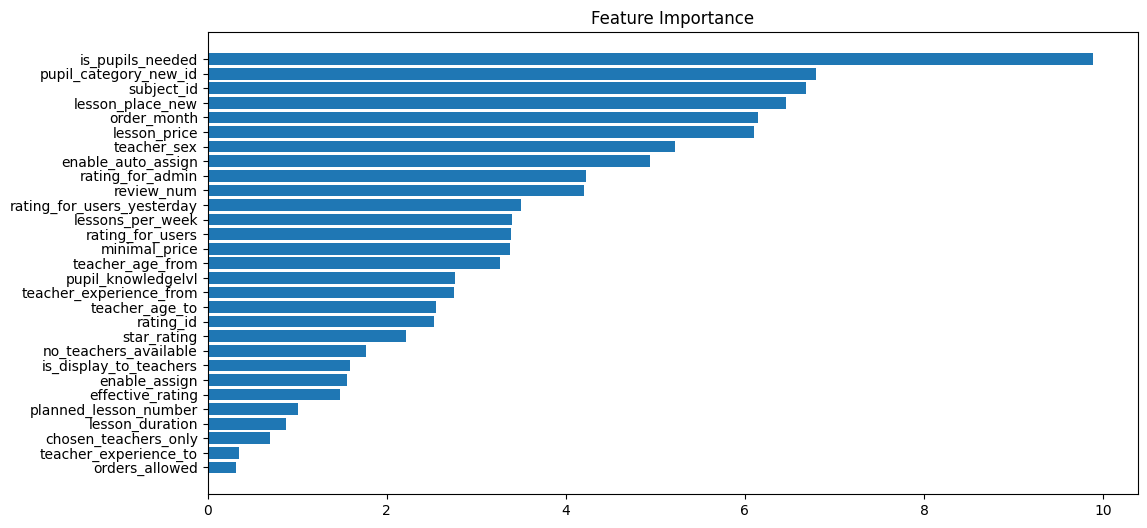

In [88]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')

# Вывод и рекомендации по проделанной работе. 

Анализируя полученные метрики, а также значение ключевой метрики recall можно судить о неплохом результате работы модели.

В данном работе в дальнейшем я бы рекомендовал следующие улучшения:

1. Преобразовать текстовые признаки в признаки для обучения, используя либо трансформеры, либо tf_idf.
2. Добавить больше графиков для презентабельности работы.
3. Рассмотреть распределение классов в выборках.